# Convolutional Network - Baseline Version

## Summary of the network
>## Summary of the network
>
> **Network structure**
* conv1/kernel:0' shape=(5, 5, 3, 64)
* conv1/bias:0' shape=(64,)
* conv2/kernel:0' shape=(3, 3, 64, 64)
* conv2/bias:0' shape=(64,)
* dense/kernel:0' shape=(1024, 256)
* dense/bias:0' shape=(256,)
* dense_1/kernel:0' shape=(256, 4)
* dense_1/bias:0' shape=(4,)
>
>**Hyper-parameters**: Loss function: Mean cross-entropy; Adam optimizer
>
>**Accuracy on test (tarining data set) = 0.792**

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

import tensorflow as tf

import random
from sklearn import ensemble

from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Activate Seaborn style
sns.set()

C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-

## Import data

In [2]:
# Load the npz file
with np.load('Cifar4-train.npz', allow_pickle=False) as cifar_df:
    # It's a dictionary-like object
    cifar4 = dict(cifar_df.items())

# Convert pixels into floating point numbers
data = cifar4['pixels'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255
    

In [3]:
X=data
y=cifar4['labels']
names=cifar4['names']

print(X.shape, X.dtype)
print(y.shape, y.dtype)
print(names.shape, names.dtype)

(5000, 3072) float32
(5000,) int64
(4,) <U8


In [4]:
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Reshape images: 32 by 32 with 3 (RGB) color channels
    data.reshape(-1, 32, 32, 3),
    cifar4['labels'],
    test_size=1800, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3200, 32, 32, 3) (3200,)
Valid: (800, 32, 32, 3) (800,)
Test: (1000, 32, 32, 3) (1000,)


In [5]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Create the ConvNet

In [6]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print('Input:', X.shape)
    
    # Convolutional layer (64 filters, 5x5, stride: 2)
    conv1 = tf.layers.conv2d(
        X, 64, (5, 5), (2, 2), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv1'
    )
    print('Convolutional layer:', conv1.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool1.shape)
    
    # Convolutional layer (64 filters, 3x3, stride: 1)
    conv2 = tf.layers.conv2d(
        pool1, 64, (3, 3), (1, 1), 'SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),
        name='conv2'
    )
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:', flat_output.shape)
    
    # Dropout
    training = tf.placeholder(dtype=tf.bool)
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256, # 256 hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc1, 4, # One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    print('Output layer:', logits.shape)
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Kernel of the output layer
    with tf.variable_scope('output', reuse=True):
        conv_kernels_output = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Input: (?, 32, 32, 3)
Convolutional layer: (?, 16, 16, 64)
Maxpool: (?, 8, 8, 64)
Convolutional layer: (?, 8, 8, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 4)


## Train the model

In [7]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_train, y_train, 100): # with batch size 64; accuracy on test = 0.781
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Get 1st conv. layer kernels
    kernels1 = conv_kernels1.eval()
    
    # Get output conv. layer kernels
    kernels2 = conv_kernels_output.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test,
            training: False
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.496 train: 0.422 (mean)
Epoch 2 - valid: 0.559 train: 0.518 (mean)
Epoch 3 - valid: 0.584 train: 0.558 (mean)
Epoch 4 - valid: 0.627 train: 0.584 (mean)
Epoch 5 - valid: 0.635 train: 0.607 (mean)
Epoch 6 - valid: 0.654 train: 0.638 (mean)
Epoch 7 - valid: 0.685 train: 0.660 (mean)
Epoch 8 - valid: 0.692 train: 0.674 (mean)
Epoch 9 - valid: 0.695 train: 0.695 (mean)
Epoch 10 - valid: 0.695 train: 0.723 (mean)
Epoch 11 - valid: 0.689 train: 0.722 (mean)
Epoch 12 - valid: 0.729 train: 0.733 (mean)
Epoch 13 - valid: 0.735 train: 0.754 (mean)
Epoch 14 - valid: 0.740 train: 0.769 (mean)
Epoch 15 - valid: 0.748 train: 0.780 (mean)
Epoch 16 - valid: 0.760 train: 0.797 (mean)
Epoch 17 - valid: 0.750 train: 0.795 (mean)
Epoch 18 - valid: 0.750 train: 0.807 (mean)
Epoch 19 - valid: 0.740 train: 0.824 (mean)
Epoch 20 - valid: 0.760 train: 0.824 (mean)
Epoch 21 - valid: 0.755 train: 0.824 (mean)
Epoch 22 - valid: 0.769 train: 0.823 (mean)
Epoch 23 - valid: 0.769 train: 0.856 (mea

In [8]:
#Save the accuracy of the Best CNN 1 2 conv layers
CNN_1_2convlyr=0.792
%store CNN_1_2convlyr

Stored 'CNN_1_2convlyr' (float)


## Visualize first convolutional layer of the network

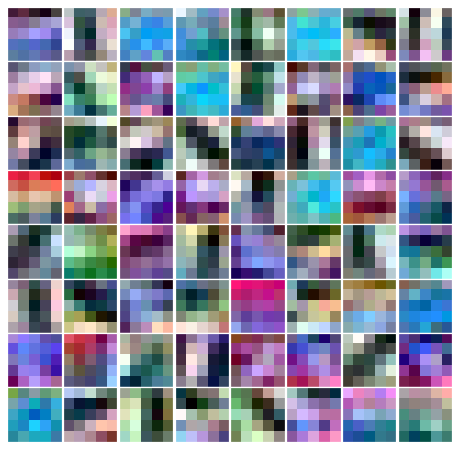

In [9]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel1 = kernels1[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel1 -= kernel1.min() # Rescale between 0 and max
    kernel1 /= kernel1.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel1)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()